<a href="https://colab.research.google.com/github/kevininhe/MachineLearning/blob/main/Deep_Learning_Taller_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image](https://docs.google.com/uc?export=download&id=1NUy1Q-abpoV9XYK9qT9t8Mdhj3ZVlveO)

# **Taller 2**
## **Construcción de modelo para la clasificación de imágenes de retina con enfermedades oculares**

## **Objetivos**
*   Realizar la carga de imágenes de retinas con enfermedades oculares para entrenar una Red Neuronal usando el CLI de Kaggle.
*   Crear una red convolucional unida a un perceptron multicapa para la clasificación de imágenes de retinas con enfermedades oculares.
*   Usar dos redes convolucionales preentrenadas unidas a un perceptron multicapa para la clasificación de imágenes de retinas con enfermedades oculares.


## **Problema**
Utilizando el conjunto de imágenes llamado [preprocessed_eye_diseases_fundus_images](https://www.kaggle.com/datasets/gunavenkatdoddi/preprocessed-eye-diseases-fundus-images), el cual consta de alrededor de 4000 imágenes RGB de retinas, se debe crear un modelo capaz de clasificar imágenes de retinas en una de las siguientes 4 categorías:

*   Normal
*   Catarata
*   Glaucoma
*   Retinopatía Diabética

El set de imágenes cuenta con 1000 imágenes aproximadamente por cada categoría.





### 0. Importación de paquetes

A continuación se importan las librerías utilizadas en para la creación de los modelos y su entrenamiento

In [1]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 7.9 MB/s 
     |████████████████████████████████| 1.6 MB 48.3 MB/s 


In [2]:
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

#from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
#from tensorflow.keras.utils import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Input, GlobalAveragePooling2D, Rescaling, MaxPooling2D, Conv2D

# Modelos preentrenados
from tensorflow.keras.applications import MobileNetV2

import keras_tuner as kt
from sklearn.metrics import classification_report, confusion_matrix

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.9.2


### 1. Entendimiento del Negocio

El conjunto de imágenes [preprocessed_eye_diseases_fundus_images](https://www.kaggle.com/datasets/gunavenkatdoddi/preprocessed-eye-diseases-fundus-images) consta del siguiente diccionario de datos:

Las imágenes de retina están almacenadas en 4 carpetas diferentes, correspondientes a las categorías en las que están clasificadas. A continuación se listan las categorías y la cantidad de imágenes disponibles por cada categoría:


1.   Cataract (Cataratas): 1038 imágenes
2.   diabetic_retinopathy (Retinopatía Diabética): 1098 imágenes
3.   glaucoma (Glaucoma): 1007 imágenes
4.   normal (Normal): 1074 imágenes

Todas las imágenes son RGB y están enfocadas solamente en la retina, tal como se ve a continuación.

**Normal**
![image](https://drive.google.com/uc?export=view&id=1BMtt0Y2AZyIpzHtmccsEzDfyApqqhCIA)

**Glaucoma**
![image](https://drive.google.com/uc?export=view&id=1F7kxaeXjPIMie9TrulCAxvXpBC6dUkFu)

**Catarata**
![image](https://drive.google.com/uc?export=view&id=1Zri96fAjuo0ALvQSqi1bzSgcpbjEHrja)

**Retinopatía diabética**
![image](https://drive.google.com/uc?export=view&id=1kj9XVG7YPVcr61Eplgyzj2HZTJ0KKiUS)

Aquellos pixeles en los que no hay imágen de retina están en negro.

A simple vista pareciera que las categorías más fáciles de clasificar son Retinopatía Diabética, ya que tiene marcas visibles en la retina, y Glaucoma, ya que al parecer la retina tiene una tendencia a ser de color rojo.

### 2. Entendimiento de los Datos

Se cargan los datos en el notebook usando el CLI de Kaggle y [el siguiente tutorial](https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/).

In [5]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download gunavenkatdoddi/preprocessed-eye-diseases-fundus-images
! unzip preprocessed-eye-diseases-fundus-images.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
 97% 456M/472M [00:03<00:00, 181MB/s]
100% 472M/472M [00:04<00:00, 122MB/s]
Archive:  preprocessed-eye-diseases-fundus-images.zip
  inflating: seg_dataset/cataract/0_left.jpg  
  inflating: seg_dataset/cataract/103_left.jpg  
  inflating: seg_dataset/cataract/1062_right.jpg  
  inflating: seg_dataset/cataract/1083_left.jpg  
  inflating: seg_dataset/cataract/1084_right.jpg  
  inflating: seg_dataset/cataract/1102_left.jpg  
  inflating: seg_dataset/cataract/1102_right.jpg  
  inflating: seg_dataset/cataract/1115_left.jpg  
  inflating: seg_dataset/cataract/1126_right.jpg  
  inflating: seg_dataset/cataract/112_right.jpg  
  inflating: seg_dataset/cataract/1144_left.jpg  
  inflating: seg_dataset/cataract/1144_right.jpg  
  inflating: seg_dataset/cataract/1164_left.jpg  
  inflating: seg_dataset/cataract/1167_right.jpg  
  inflati

Se revisa la estructura de las imágenes que fueron descargadas desde Kaggle

In [6]:
!ls -l seg_dataset

total 144
drwxr-xr-x 2 root root 36864 Oct 16 02:26 cataract
drwxr-xr-x 2 root root 36864 Oct 16 02:26 diabetic_retinopathy
drwxr-xr-x 2 root root 36864 Oct 16 02:26 glaucoma
drwxr-xr-x 2 root root 36864 Oct 16 02:26 normal


Una vez descomprimido el dataset descargado desde Kaggle, las imágenes quedaron en la carpeta "seg_dataset" cuyo contenido son las 4 carpetas correspondientes a las 4 categorías en las que se clasifican las imágenes del dataset: cataract, diabetic_retinopathy, glaucoma y normal. Cada una de estas carpetas contiene las imágenes de retina correspondientes a dicha categoría.

Esta disposición de las imágenes permitirá usar la función `image_dataset_from_directory` de Tensorflow para realizar la carga y tratamiento del dataset.

# Creación modelos de redes convolucionales

A continuación se procederá a desarrollar la preparación de datos, modelamiento y evaluación tanto de una red convolucional propia como de dos redes convolucionales preentrenadas. Ya que cada red convolucional preentrenada puede requerir diferentes tamaños de imágen, es necesario que para cada una se realice una preparación de datos diferente.

Los modelos convolucionales preentrenados que se usarán en este laboratorio son MobileNetV2 y |OTRO_MODELO MAS COMPLEJO|, ya que se busca medir de primera mano que tanto varían métricas como la precisión y velocidad de clasificación al usar el modelo más simple que se muestra en "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 3rd Edition" y al usar un modelo más complejo, y además se busca saber qué tanto se pueden mejorar los resultados de clasificación cuando se pasa de usar una red neuronal propia a usar la red preentrenada más simple.

## Creación de red neuronal propia

### 3. Preparación de datos

Se definen el tamaño del batch y el tamaño de las imágenes a cargar.

In [ ]:
batch_size = 32
img_height = 256
img_width = 256

Se usa la función `image_dataset_from_directory` de TensorFlow para realizar la carga de las imágenes, obteniendo de paso los sets de validación y test.

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/seg_dataset',
  label_mode='categorical',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4217 files belonging to 4 classes.
Using 3374 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/seg_dataset',
  label_mode='categorical',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4217 files belonging to 4 classes.
Using 843 files for validation.


Se verifican las clases cargadas

In [ ]:
class_names = train_ds.class_names
print(class_names)

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


Y se revisan algunas imágenes para verificar que tengan las dimensiones correctas y hacerse una idea de que imagen corresponde a cada categoría.

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


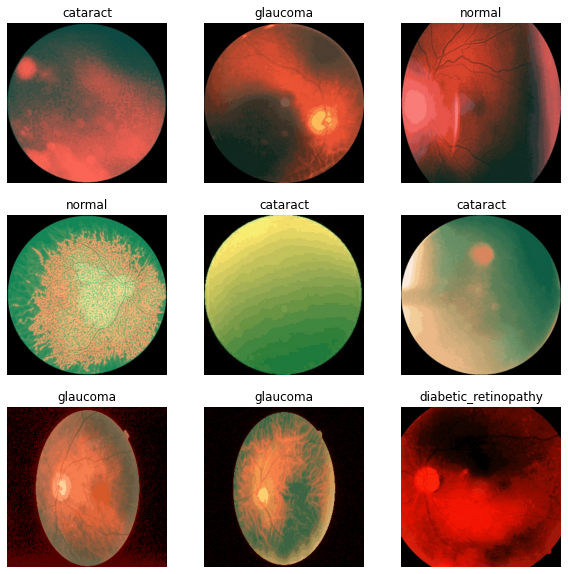

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        print(images[i].numpy().shape)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().argmax()])
        plt.axis("off")

Tal como se espera, las dimensiones de las imágenes son 256 x 256 x 3, ya que son imágenes RGB con tamaño 256 x 256.

### 4. Modelamiento

Se procede a construir un modelo de prueba, y sobre este se realizará la búsqueda de hiperparámetros.

#### 4.1 Modelo de prueba

Se utilizará un modelo similar al visto en la práctica 1 del Laboratorio 2, solo que en este caso se usará `padding=same` en las capas convolucionales de modo que no se dejen por fuera los píxeles de los extremos y la salida de las capas convolucionales tenga el mismo tamaño que su entrada. 

Además, las capas de Pooling serán de `MaxPooling` ya que, de acuerdo al libro "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 3rd Edition", este es el tipo de Pooling usado más frecuentemente para redes convolucionales de clasificación de imágenes.

Definición del modelo

In [ ]:
model_test = Sequential(name="RNC_Retina_Test")

Capas de preparación de datos

In [ ]:
model_test.add(Input(shape=(img_height, img_width,3),batch_size=None,name='Capa_Entrada'))
model_test.add(Rescaling(1./255,name='Capa_Reescalado'))

model_test.summary()

Model: "RNC_Retina_Test"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Capa_Reescalado (Rescaling)  (None, 256, 256, 3)      0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


Capas de Entrenamiento

A medida que se agregan capas convolucionales al modelo se van reduciendo la cantidad de mapas de características por cada capa, y las capas de 2 x 2 de Max Pooling van reduciendo las dimensiones de los mapas de caracteristicas a la mitad, de modo que la representación de la imagen que se obtiene al final sea más simplificada, teniendo en cuenta que su salida se debe aplanar para ser tomada por un MLP.

In [ ]:
model_test.add(Conv2D(128, (3, 3), activation='relu', name='Capa_Convolucional_1', padding="same"))
model_test.add(MaxPooling2D((2, 2), name='Max_Pool_1'))
model_test.add(Conv2D(64, (3, 3), activation='relu', name='Capa_Convolucional_2', padding="same"))
model_test.add(MaxPooling2D((2, 2), name='Max_Pool_2'))
model_test.add(Conv2D(32, (3, 3), activation='relu', name='Capa_Convolucional_3', padding="same"))
model_test.summary()

Model: "RNC_Retina_Test"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Capa_Reescalado (Rescaling)  (None, 256, 256, 3)      0         
                                                                 
 Capa_Convolucional_1 (Conv2  (None, 256, 256, 128)    3584      
 D)                                                              
                                                                 
 Max_Pool_1 (MaxPooling2D)   (None, 128, 128, 128)     0         
                                                                 
 Capa_Convolucional_2 (Conv2  (None, 128, 128, 64)     73792     
 D)                                                              
                                                                 
 Max_Pool_2 (MaxPooling2D)   (None, 64, 64, 64)        0         
                                                                 
 Capa_Convolucional_3 (Conv2  (None, 64, 64, 32)   

Capa de entrenamiento (Perceptron Multicapa)

In [ ]:
model_test.add(Flatten(name='Flatten_Layer'))
model_test.add(Dense(100,activation='relu',name='Capa_Densa_1'))
model_test.add(Dense(50,activation='relu',name='Capa_Densa_2'))
model_test.summary()

Model: "RNC_Retina_Test"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Capa_Reescalado (Rescaling)  (None, 256, 256, 3)      0         
                                                                 
 Capa_Convolucional_1 (Conv2  (None, 256, 256, 128)    3584      
 D)                                                              
                                                                 
 Max_Pool_1 (MaxPooling2D)   (None, 128, 128, 128)     0         
                                                                 
 Capa_Convolucional_2 (Conv2  (None, 128, 128, 64)     73792     
 D)                                                              
                                                                 
 Max_Pool_2 (MaxPooling2D)   (None, 64, 64, 64)        0         
                                                                 
 Capa_Convolucional_3 (Conv2  (None, 64, 64, 32)   

Capa de Salida

In [ ]:
model_test.add(Dense(len(class_names),activation='softmax',name='Capa_Respuesta'))
model_test.summary()

Model: "RNC_Retina_Test"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Capa_Reescalado (Rescaling)  (None, 256, 256, 3)      0         
                                                                 
 Capa_Convolucional_1 (Conv2  (None, 256, 256, 128)    3584      
 D)                                                              
                                                                 
 Max_Pool_1 (MaxPooling2D)   (None, 128, 128, 128)     0         
                                                                 
 Capa_Convolucional_2 (Conv2  (None, 128, 128, 64)     73792     
 D)                                                              
                                                                 
 Max_Pool_2 (MaxPooling2D)   (None, 64, 64, 64)        0         
                                                                 
 Capa_Convolucional_3 (Conv2  (None, 64, 64, 32)   

Compilación del modelo,eligiendo como métrica solamente la precisión ya que la idea es garantizar que el modelo sea lo más preciso posible a la hora de predecir una u otra enfermedad, más que asegurarse de que cada categoría contenga todas las ocurrencias posibles. Por ende, más que almacenar varias métricas a la vez, en este caso solo se almacena la métrica de interés, que es la precisión.

In [ ]:
model_test.compile(loss='categorical_crossentropy', optimizer='adam',metrics=[tf.keras.metrics.Precision()])
model_test.summary()

Model: "RNC_Retina_Test"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Capa_Reescalado (Rescaling)  (None, 256, 256, 3)      0         
                                                                 
 Capa_Convolucional_1 (Conv2  (None, 256, 256, 128)    3584      
 D)                                                              
                                                                 
 Max_Pool_1 (MaxPooling2D)   (None, 128, 128, 128)     0         
                                                                 
 Capa_Convolucional_2 (Conv2  (None, 128, 128, 64)     73792     
 D)                                                              
                                                                 
 Max_Pool_2 (MaxPooling2D)   (None, 64, 64, 64)        0         
                                                                 
 Capa_Convolucional_3 (Conv2  (None, 64, 64, 32)   

Callback de parada temprana

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3)
]

Entrenamiento del modelo

Revisar si se tiene disponible una GPU

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Entrenar usando GPU

In [ ]:
history = None
with tf.device('/device:GPU:0'): 
  history = model_test.fit(train_ds,
          validation_data=val_ds,
          epochs=50,
          callbacks=my_callbacks
      )

Epoch 1/50
106/106 [==============================] - 43s 231ms/step - loss: 0.8992 - precision: 0.7246 - val_loss: 0.7245 - val_precision: 0.7256
Epoch 2/50
106/106 [==============================] - 24s 218ms/step - loss: 0.6682 - precision: 0.7586 - val_loss: 0.6730 - val_precision: 0.8043
Epoch 3/50
106/106 [==============================] - 26s 231ms/step - loss: 0.6248 - precision: 0.7739 - val_loss: 0.6485 - val_precision: 0.7645
Epoch 4/50
106/106 [==============================] - 23s 209ms/step - loss: 0.5525 - precision: 0.7960 - val_loss: 0.6130 - val_precision: 0.7625
Epoch 5/50
106/106 [==============================] - 24s 212ms/step - loss: 0.5284 - precision: 0.8052 - val_loss: 0.6364 - val_precision: 0.7351
Epoch 6/50
106/106 [==============================] - 24s 213ms/step - loss: 0.4719 - precision: 0.8285 - val_loss: 0.6955 - val_precision: 0.7444
Epoch 7/50
106/106 [==============================] - 24s 212ms/step - loss: 0.4574 - precision: 0.8323 - val_loss: 0.

Dado que la pérdida calculada para los datos de validación comenzó a aumentar en vez de disminuir en las tres últimas épocas, el callback de early stopping hizo que se detuviera la compilación del modelo.

##### 4.1.1 Predicción

Se genera la matriz de confusión generada sobre los datos de entrenamiento, realizando primero la transformación de los datos para poder generar la matriz

In [ ]:
y_true = list()
y_pred = list()

for images, labels in train_ds:
    pred = model_test.predict(images)
    for i in range(len(pred)):
        y_true.append(labels[i].numpy())
        y_pred.append((pred[i] == pred[i].max()).astype(int))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 [==============================] - 0s 80ms/step


Matriz de confusión

In [ ]:
print(classification_report(y_true,y_pred,target_names=list(class_names)))

                      precision    recall  f1-score   support

            cataract       0.96      0.39      0.56       836
diabetic_retinopathy       0.99      1.00      1.00       884
            glaucoma       0.58      0.91      0.71       802
              normal       0.83      0.85      0.84       852

           micro avg       0.79      0.79      0.79      3374
           macro avg       0.84      0.79      0.77      3374
        weighted avg       0.84      0.79      0.78      3374
         samples avg       0.79      0.79      0.79      3374



Se muestran unos valores de precisión relativamente altos para las categorías "cataratas" y "retinopatía diabética", mientras que los valores de "Glaucoma" y "Normal" son los mucho más bajos, siendo la categoría de Glaucoma la más baja de todas, con una probabilidad cercana a lanzar una moneda al aire.
Por otra parte, parece ser que la capacidad de generalización del modelo no es muy buena ya que la pérdida calculada sobre los datos de validación aumentaba a medida que se avanzaban en las épocas, lo cual indica que el modelo está sobre ajustado.

Para verificar si el modelo está sobre ajustado, se grafica el comportamiento de los valores de pérdida tanto para el dataset de entrenamiento como para el dataset de validación.

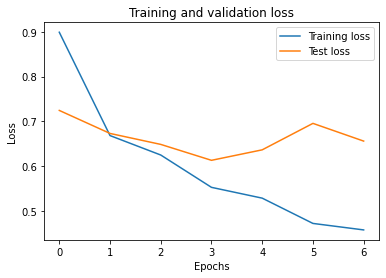

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Test loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Se puede ver que a partir de la tercera época las pérdidas sobre los datos de training y de validación comienzan a tener comportamientos completamente opuestos, ya que la pérdida de valoración aumenta mientras que la pérdida de entrenamiento disminuye, lo cual indica que el modelo no tiene una buena capacidad de generalización y está sobreajustado. Al final de la última época la pérdida sobre los datos de entrenamiento es muy pequeña, mientras que la pérdida sobre los datos de validación ronda los 0.7.

Esto podría ser un indicador también de que se tienen muy pocos datos para construir un modelo, ya que apenas se tienen un poco más de 4000 imágenes, por lo que se debería usar un modelo preentrenado.

Comportamiento de la métrica de calidad (precisión).

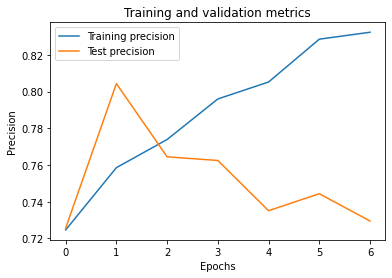

In [ ]:
plt.plot(history.history['precision'], label='Training precision')
plt.plot(history.history['val_precision'], label='Test precision')
plt.title('Training and validation metrics')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

La precisión sobre los datos de validación se intentó aumentar en la primera época, sin embargo, a medida que se avanzó en el tiempo en vez de seguir aumentando fue disminuyendo, mientras que la precisión con los datos de training iba en aumento, lo cual es otra muestra de que el modelo está sobreajustado.

#### 4.2 Búsqueda de hiperparámetros - Mejor modelo

Se utiliza el Random Search de Keras Tuner para la búsqueda de Hiperparámetros. Al igual que se hizo en el modelo de entrada, se utiliza el `padding=same ` para que la salida de la capa convolucional tenga el mismo tamaño de la entrada y así no dejar de lado los píxeles de los bordes.

Por otra parte, el número de filtros usados en las capas convolucionales disminuye a medida que se avanzan en las capas, de modo que se obtenga una representación más simple.

También se están probando dos optimizadores: sgd y adam.

Finalmente, el enfoque está principalmente en incrementar la precisión, ya que al estarse detectando diferentes enfermedades en la retina, el interés está en que la clasificación esté bien hecha más que en obtener todos los elementos que estén en una categoría, por lo cual el objetivo del keras tuner se estableció como "`val_precision`" (aumentar la precisión en los datos de validación).

In [ ]:
def entrenarRed(hp):
    clf = Sequential(name='Red_Encontrada')
    output = len(class_names)
    n_layers_DCN = hp.Choice('n_layers_DCN', [1, 2, 3])
    filtros = hp.Choice('filtros', ['[128, 64, 32]','[200, 100, 50]','[256, 128, 64]'])
    n_layers_MLP = hp.Choice('n_layers_MLP', [1, 2, 3])
    neuronas_MLP = hp.Choice('neuronas_MLP', ['[100, 50, 20]','[10, 20, 30]','[32, 16, 8]'])
    dropout = hp.Choice('dropout', [0.1,0.3,0.5])
    optimizadores = hp.Choice('optimizadores',['sgd','adam'])
    
    filtros = eval(filtros)
    neuronas_MLP = eval(neuronas_MLP)

    clf.add(Input(shape=(img_height, img_width,3),batch_size=None,name='Capa_Entrada'))
    clf.add(Rescaling(1./255,name='Capa_Reescalado'))

    for i in range(n_layers_MLP):
        clf.add(Conv2D(filtros[i], (3, 3), activation='relu', name='Capa_Convolucional_{0}'.format(i),padding="same"))
        clf.add(MaxPooling2D((2, 2), name='Max_Pool_{0}'.format(i)))

    clf.add(Flatten(name='Flatten_Layer'))
    for i in range(n_layers_MLP):
        clf.add(Dense(neuronas_MLP[i], activation='relu', name = 'Capa_Oculta_MLP_{0}'.format(i)))
        clf.add(Dropout(dropout,name='Dropout_{0}_{1}'.format(dropout,i)))

    clf.add(Dense(output, activation='softmax', name= 'Capa_Respuesta'))

    clf.compile(loss='categorical_crossentropy',
                optimizer=optimizadores,
                metrics=["accuracy",tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return clf

tuner = kt.RandomSearch(
    entrenarRed,
    objective=kt.Objective("val_precision", direction="max"),
    project_name="retina_disease_detection",
    seed=123,
    max_trials=10)

Se procede a realizar la búsqueda de hiperparámetros

In [ ]:
with tf.device('/device:GPU:0'): 
    tuner.search(train_ds,
             validation_data=val_ds,
             callbacks=my_callbacks,
             epochs=30)
    
best_model = tuner.get_best_models()[0]

Trial 10 Complete [00h 04m 50s]
val_precision: 0.786707878112793

Best val_precision So Far: 0.9925925731658936
Total elapsed time: 01h 15m 02s


Se almacena el modelo y se revisan sus caracteristicas

In [ ]:
best_model.save('best_model_retina_diseases.h5')
best_model.summary()

Model: "Red_Encontrada"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Capa_Reescalado (Rescaling)  (None, 256, 256, 3)      0         
                                                                 
 Capa_Convolucional_0 (Conv2  (None, 256, 256, 256)    7168      
 D)                                                              
                                                                 
 Max_Pool_0 (MaxPooling2D)   (None, 128, 128, 256)     0         
                                                                 
 Capa_Convolucional_1 (Conv2  (None, 128, 128, 128)    295040    
 D)                                                              
                                                                 
 Max_Pool_1 (MaxPooling2D)   (None, 64, 64, 128)       0         
                                                                 
 Flatten_Layer (Flatten)     (None, 524288)         

Se ve que en general este modelo es mucho más simple que el modelo de prueba, ya que dicho modelo cuenta con aproximadamente 13 millones de parámetros mientras que este cuenta con 5.5 millones de parámetros.

En este modelo se tiene apenas una capa convolucional de 256 x 256 con Max Pooling, mientras que el modelo de prueba contaba con 3 capas convolucionales con Max Pooling, y en el MLP se tienen dos capas ocultas, la primera con 10 neuronas y la siguiente con 20 neuronas, mientras que en el modelo de prueba el MLP también tiene dos capas pero la primera con 100 neuronas y la segunda con 50 neuronas.

A primera vista se esperaría que el mejor modelo tuviese más capas convolucionales, sin embargo, solo se hizo una búsqueda sobre 10 posibles modelos seleccionados aleatoriamente dadas las limitaciones de capacidad, por lo cual podría suceder que el "mejor modelo" en realidad no sea el mejor. O bien podría suceder que este modelo no esté tan sobreajustado como el modelo de prueba. Esto se verá a continuación.

##### 4.2.1 Predicción

Se genera la matriz de confusión generada sobre los datos de entrenamiento, realizando primero la transformación de los datos para poder generar la matriz

In [ ]:
y_true_best_model = list()
y_pred_best_model = list()

for images, labels in train_ds:
    pred = best_model.predict(images)
    for i in range(len(pred)):
        y_true_best_model.append(labels[i].numpy())
        y_pred_best_model.append((pred[i] == pred[i].max()).astype(int))

1/1 [==============================] - 0s 76ms/step


Matriz de confusión

In [ ]:
print(classification_report(y_true_best_model,y_pred_best_model,target_names=list(class_names)))

                      precision    recall  f1-score   support

            cataract       0.54      0.30      0.39       836
diabetic_retinopathy       0.99      0.75      0.85       884
            glaucoma       0.00      0.00      0.00       802
              normal       0.37      0.99      0.54       852

           micro avg       0.52      0.52      0.52      3374
           macro avg       0.48      0.51      0.45      3374
        weighted avg       0.49      0.52      0.46      3374
         samples avg       0.52      0.52      0.52      3374



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


A pesar de la búsqueda realizada, en realidad los puntajes empeoraron con respecto al modelo de prueba, donde el Glaucoma era al menos del 58% y no 0 como en este caso. Sin embargo, esto confirma que la categoría del Glaucoma es la más difícil de clasificar.

A diferencia del modelo de prueba, que parecía estar sobre ajustado, este modelo parece estar bajo ajustado. Esto se podría mejorar si se aumenta el número de posibles mejores modelos que se puedan evaluar aleatoriamente (en este trabajo se evaluaron 10), de modo que se pueda encontrar el mejor modelo. Sin embargo, la capacidad limitada de cómputo haría de esta una tarea muy demorada, por lo cual se debe optar por otras alternativas como usar un modelo preentrenado.

### 5. Evaluación

#### 5.1 Modelo de prueba

Se genera la matriz de confusión del modelo de prueba con los datos de validación. Dada el sobreajuste del modelo detectado en la sección 4.1.1, se espera que los valores de la matriz de confusión sean bajos.

In [ ]:
y_true = list()
y_pred = list()

for images, labels in val_ds:
    pred = model_test.predict(images)
    for i in range(len(pred)):
        y_true.append(labels[i].numpy())
        y_pred.append((pred[i] == pred[i].max()).astype(int))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 [==============================] - 0s 56ms/step


In [ ]:
print(classification_report(y_true,y_pred,target_names=list(class_names)))

                      precision    recall  f1-score   support

            cataract       0.72      0.29      0.41       202
diabetic_retinopathy       0.98      0.99      0.98       214
            glaucoma       0.50      0.76      0.60       205
              normal       0.72      0.75      0.73       222

           micro avg       0.70      0.70      0.70       843
           macro avg       0.73      0.70      0.68       843
        weighted avg       0.73      0.70      0.69       843
         samples avg       0.70      0.70      0.70       843



Tal como se esperaba, se nota una baja considerable en la precisión del modelo usando los datos de validación dado su sobreajuste a los datos de entrenamiento y por ende baja capacidad de generalización.

Sin embargo, parece ser que la categoría que mejor clasifica el modelo es "retinopatía diabética", la cual, de hecho, tiene valores de precisión de mínimo 20% más alto que todas las demás categorías. Esto se observó también cuando se hizo la matriz de confusión con los datos de entrenamiento, donde la categoría "retinopatía diabética" fue la que obtuvo un mayor porcentaje de precisión.

#### 5.2 Mejor modelo

Dados los resultados de clasificación del mejor modelo presentados en 4.2.1, se espera que la clasificación realizada con los datos de prueba en realidad no sea buena.

Se transforman los datos para poder generar la matriz de confusión.

In [ ]:
y_true_best_model = list()
y_pred_best_model = list()

for images, labels in val_ds:
    pred = best_model.predict(images)
    for i in range(len(pred)):
        y_true_best_model.append(labels[i].numpy())
        y_pred_best_model.append((pred[i] == pred[i].max()).astype(int))

1/1 [==============================] - 0s 22ms/step


Finalmente se genera la matriz de confusión

In [ ]:
print(classification_report(y_true_best_model,y_pred_best_model,target_names=list(class_names)))

                      precision    recall  f1-score   support

            cataract       0.51      0.24      0.32       202
diabetic_retinopathy       0.99      0.79      0.88       214
            glaucoma       0.00      0.00      0.00       205
              normal       0.38      1.00      0.55       222

           micro avg       0.52      0.52      0.52       843
           macro avg       0.47      0.51      0.44       843
        weighted avg       0.47      0.52      0.45       843
         samples avg       0.52      0.52      0.52       843



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Se obtuvieron resultados similares a los obtenidos con los datos de entrenamiento, lo cual muestra que este modelo no es capaz de realizar una clasificación confiable y que se debe, o bien aumentar el número de modelos aleatorios a evaluar, lo cual puede tomar mucho tiempo, o probar con un modelo preentrenado, lo cual se hará a continuación.

## Uso de red neuronal Preentrenada - MobileNet

### Descripción de la red

Tal como lo explica Aurélien Géron en el capitulo 14 de su libro "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 3rd Edition", particularmente en la sección "CNN Arquitectures", los avances que se han realizado sobre los modelos de redes convolucionales para la clasificación categórica de imágenes han mostrado que el tener un buen modelo no necesariamente está relacionado con que este tenga más y más parámetros, sino que está relacionado con otros factores como la profundidad de la red y las técnicas que se usan para la construcción de las diferentes capas del modelo. De hecho hay una tendencia en ir reduciendo la cantidad de parámetros pero ir aumentando también la profundidad de la arquitectura.

MobileNet es una arquitectura diseñada para ser ligera y rápida, pensada para casos de uso en los que se tenga una capacidad de procesamiento limitada como es el caso de los dispositivos móviles o las páginas web.

Su arquitectura se basa en "capas convolucionales separables por profundidad" (depthwise separable convolution layers), que también fueron el eje central de la arquitectura "Xception" (Extreme Inception), propuesta en 2016 por François Chollet, el autor de Keras.

Estas capas convolucionales separables analizan por separado los patrones espaciales (óvalo, por ejemplo) y los patrones multi-canal (ojos, nariz y boca = cara, por ejemplo), lo cual es una variación a lo que se hace con las capas Inception, que están solamente orientadas a analizar patrones multi-canal.

En este laboratorio se usará la versión 2 de esta red, llamada MobileNetV2, la cual fue propuesta en 2018 por Google. El paper correspondiente se encuentra en este [enlace](https://arxiv.org/abs/1801.04381).

Si bien los puntajes de precisión de MobileNet no son tan altos como los de otras redes más complejas como Inception, son relativamente buenos (90.1% de precisión top-5 sobre los datos de validación del Dataset "ImageNet", mientras que el modelo más complejo (EfficientNetB7) con 66.7M de parámetros ha alcanzado el 97%). En este laboratorio se busca comparar que tan buena es la precisión con respecto a una arquitectura más compleja, y también con respecto al modelo propio construido en la sección anterior.

| Nombre Arq.  | Tamaño (MB)   |Top-5 prec|# Params|Tiempo de inferencia por paso CPU (ms)| Profundidad
| ----------- | ----------- |----------- |----------- |----------- |---|
| MobileNetV2 | 14 MBs      |90.1%|3.5M|25.9|105


### Arquitectura de la red

![image](https://drive.google.com/uc?export=view&id=1dje862NM0JJDIRfLZo8HFehF9uOIijui)

Esta arquitectura comprende dos tipos de bloques convolucionales: Uno "residual" tal como los que se usan en la arquitectura ResNet con stride de 1, y el otro que es un bloque normal pero con stride de 2 para ir reduciendo el tamaño de la imagen. Nótese como en el bloque "residual" la entrada "salta" hacia la salida (skip connection), generando el llamado "aprendizaje residual" y aumentando así la velocidad de entrenamiento.

Cada uno de los bloques convolucionales tiene las siguientes tres capas, ordenadas de la primera a la última:


1.   Capa de convolución 1 x 1. 
2.   Capa de convolución "depthwise".
3.   Capa de convolución 1 x 1 con función "identidad" como activación.

En general la arquitectura es la siguiente:
![image](https://drive.google.com/uc?export=view&id=1GX0xpBUa4ogXEhByPE0wAL3FFePkCzTc)

Dónde:


*   t: Factor de expansión
*   c: Número de canales
*   n: Veces en que se repite la capa
*   s: Stride.

### 3. Preparación de datos

De acuerdo a la documentación de Keras de MobileNetV2, esta soporta cualquier tamaño de imagen superior a 32 x 32, obteniendo un mejor resultado con imágenes de mayor resolución. Inicialmente se usó entonces el tamaño de imágenes 256 x 256 para inicializar el modelo, sin embargo, en este se especificaba que el tamaño debía ser máximo 224 x 224, por lo que se usa entonces este tamaño.

Se definen el tamaño del batch y el tamaño de las imágenes a cargar.

In [7]:
batch_size = 32
img_height = 224
img_width = 224

Se usa la función `image_dataset_from_directory` de TensorFlow para realizar la carga de las imágenes, obteniendo de paso los sets de validación y test.

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/seg_dataset',
  label_mode='categorical',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4217 files belonging to 4 classes.
Using 3374 files for training.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/seg_dataset',
  label_mode='categorical',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4217 files belonging to 4 classes.
Using 843 files for validation.


Se verifican las clases cargadas

In [10]:
class_names = train_ds.class_names
print(class_names)

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


Y se revisan algunas imágenes para verificar que tengan las dimensiones correctas.

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


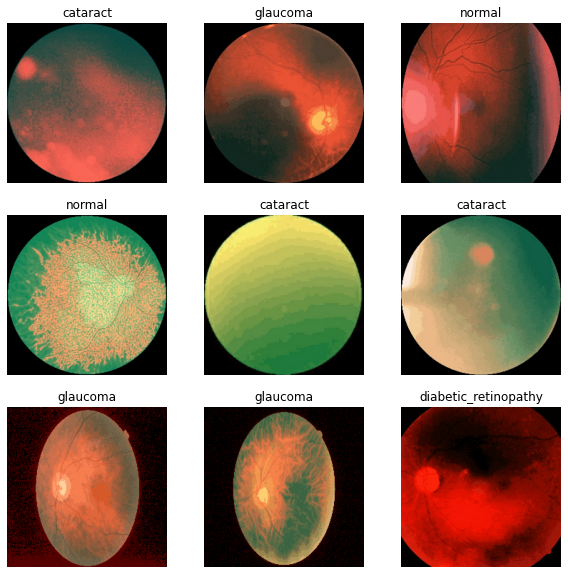

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        print(images[i].numpy().shape)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().argmax()])
        plt.axis("off")

Tal como se espera, las dimensiones de las imágenes son 224 x 224 x 3, ya que son imágenes RGB con tamaño 224 x 224.

Para MobileNetV2 se debe realizar un preprocesamiento de los Inputs. En este caso se hace para los sets de training y Validación. [Tutorial](https://www.tensorflow.org/tutorials/load_data/images)

In [12]:
normalized_train_ds = train_ds.map(lambda img, label: (tf.keras.applications.mobilenet_v2.preprocess_input(img), label))
normalized_val_ds = val_ds.map(lambda img, label: (tf.keras.applications.mobilenet_v2.preprocess_input(img), label))

Se verifica el tamaño de los pixeles en ambos datasets. Teóricamente debería estar entre -1 y 1, de acuerdo a la [documentación](https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v2/preprocess_input) de preprocess_input de MobileNetV2.

In [13]:
image_batch, labels_batch = next(iter(normalized_train_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[-1,1]`.
print("Train DS",np.min(first_image), np.max(first_image))

image_batch, labels_batch = next(iter(normalized_val_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[-1,1]`.
print("Validation DS",np.min(first_image), np.max(first_image))

Train DS -1.0 1.0
Validation DS -1.0 1.0


### 4. Modelamiento

Se utilizará la Red Preentrenada MobileNetV2.

In [14]:
base_model = MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights="imagenet",
)
# IncludeTop permite no incluir el clasificador de ImageNet, solo la arquitectura convolucional
base_model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                

Se congelan los pesos del modelo para hacer transferencia de conocimiento

In [15]:
base_model.trainable = False

#### 4.1 Modelo de prueba

Se utilizará el mismo MLP que se usó en el modelo de prueba de la red neuronal propia. Así mismo, la búsqueda de hiperparámetros solamente estará centrada en el MLP, ya que se parte de la premisa de que los pesos encontrados para la red convolucional preentrenada son los adecuados para la extracción de características.

In [14]:
clf = Sequential(name='Red_con_Conocimiento')

clf.add(base_model)
clf.add(GlobalAveragePooling2D(name='Pooling'))
clf.add(Dense(100, activation="relu", name='Dense_1'))
clf.add(Dense(50, activation="relu", name='Dense_2'))
clf.add(Dense(len(class_names), activation="softmax", name='Capa_Respuesta'))

clf.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=["acc",tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

clf.summary()

Model: "Red_con_Conocimiento"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 Pooling (GlobalAveragePooli  (None, 1280)             0         
 ng2D)                                                           
                                                                 
 Dense_1 (Dense)             (None, 100)               128100    
                                                                 
 Dense_2 (Dense)             (None, 50)                5050      
                                                                 
 Capa_Respuesta (Dense)      (None, 4)                 204       
                                                                 
Total params: 2,391,338
Trainable params: 133,

Es importante notar que el número de parámetros de MobileNet es mucho menor que el del modelo de prueba, ya que el modelo de prueba tenia alrededor de 13 Millones de parámetros mientras que MobileNet tiene alrededor de 2 Millones. Además, en este caso apenas se entrenarán 133 mil parámetros aproximadamente, ya que los parámetros de MobileNet se congelaron, lo cual reduce los recursos de los que se deben disponer para entrenar el modelo.

Callback de Parada Temprana

In [19]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_precision', patience=3, mode='max')
]

Entrenamiento del modelo

In [16]:
history = None
with tf.device('/device:GPU:0'): 
    history = clf.fit(normalized_train_ds,
        validation_data=normalized_val_ds,
        epochs=50,
        callbacks=my_callbacks
    )

Epoch 1/50
106/106 [==============================] - 35s 229ms/step - loss: 0.6555 - acc: 0.7324 - precision: 0.7918 - recall: 0.6627 - val_loss: 0.5000 - val_acc: 0.7853 - val_precision: 0.8184 - val_recall: 0.7485
Epoch 2/50
106/106 [==============================] - 23s 204ms/step - loss: 0.4522 - acc: 0.8156 - precision: 0.8434 - recall: 0.7884 - val_loss: 0.3991 - val_acc: 0.8482 - val_precision: 0.8739 - val_recall: 0.8304
Epoch 3/50
106/106 [==============================] - 21s 186ms/step - loss: 0.3627 - acc: 0.8554 - precision: 0.8750 - recall: 0.8343 - val_loss: 0.3911 - val_acc: 0.8446 - val_precision: 0.8618 - val_recall: 0.8209
Epoch 4/50
106/106 [==============================] - 21s 185ms/step - loss: 0.3091 - acc: 0.8811 - precision: 0.8941 - recall: 0.8660 - val_loss: 0.4370 - val_acc: 0.8339 - val_precision: 0.8568 - val_recall: 0.8161
Epoch 5/50
106/106 [==============================] - 26s 227ms/step - loss: 0.2543 - acc: 0.9046 - precision: 0.9167 - recall: 0.89

##### 4.1.1 Predicción

Se crea la matriz de confusión para el modelo encontrado, realizando las transformaciones previas para poder visualizar la matriz. Se utiliza el dataset normalizado, ya que es la entrada que espera el modelo.

In [17]:
y_true = list()
y_pred = list()

for images, labels in normalized_train_ds:
    pred = clf.predict(images)
    for i in range(len(pred)):
        y_true.append(labels[i].numpy())
        y_pred.append((pred[i] == pred[i].max()).astype(int))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 [==============================] - 1s 680ms/step


Generación de la matriz de confusión

In [18]:
print(classification_report(y_true,y_pred,target_names=list(class_names)))

                      precision    recall  f1-score   support

            cataract       0.90      0.99      0.94       836
diabetic_retinopathy       0.99      1.00      0.99       884
            glaucoma       0.93      0.89      0.91       802
              normal       0.96      0.90      0.93       852

           micro avg       0.94      0.94      0.94      3374
           macro avg       0.94      0.94      0.94      3374
        weighted avg       0.95      0.94      0.94      3374
         samples avg       0.94      0.94      0.94      3374



Usando el mismo MLP que en el modelo de prueba pero sin la necesidad de construir una red convolucional propia para realizar la clasificación se logró una mejora considerable con respecto a los resultados de la red convolucional propia, y eso que se está usando una de las redes preentrenadas más simples.

Mientras que el modelo de prueba la precisión mínima fue del 58% para la categoría "Glaucoma", que parece ser la más difícil de clasificar, en este modelo se la precisión mínima fue del 90% y se dio en la categoría "Catarata". También se ve un balance mucho mayor entre las precisiones de las categorías.

En cuanto a tiempos en realidad los tiempos de entrenamiento fueron similares a los del modelo de prueba con red convolucional propia. En el modelo con CNN propio el tiempo por step era 231 ms y se tuvo un total de 7 épocas, mientras que en el modelo con CNN preentrenado el tiempo por step era un poco menor (189 ms/step aproximadamente) pero se tuvo un total de 8 épocas.

#### 4.2 Búsqueda de hiperparámetros - Mejor modelo

Se utiliza el Random Search de Keras Tuner para la búsqueda de Hiperparámetros. Esta búsqueda estará enfocada en los hiperparámetros del clasificador MLP.

Se utiliza el mismo objetivo que con la búsqueda de hiperparámetros del modelo de prueba con CNN propio: val_precision.

Se encontró que al incluir las capas de Dropout, por algún motivo la categoría de Glaucoma quedaba con una probabilidad de 0, tal como sucedió con el model propio con una CNN propia, por lo cual se decidió quitar las capas de Dropout y realizar la búsqueda de hiperparámetros orientada al número de capas y neuronas por capa

In [24]:
def entrenarRed(hp):
    n_layers_MLP = hp.Choice('n_layers_MLP', [1, 2, 3])
    neuronas_MLP = hp.Choice('neuronas_MLP', ['[100, 50, 20]','[200, 100, 50]','[50, 25, 10]', '[500, 250, 100]'])
    #dropout = hp.Choice('dropout', [0.1,0.3,0.5])
    optimizadores = hp.Choice('optimizadores',['sgd','adam'])
    
    neuronas_MLP = eval(neuronas_MLP)

    clf = Sequential(name='Red_con_Conocimiento_Mejor')
    output = len(class_names)
    clf.add(base_model)
    clf.add(GlobalAveragePooling2D(name='Pooling'))

    for i in range(n_layers_MLP):
        clf.add(Dense(neuronas_MLP[i], activation='relu', name = 'Capa_Oculta_MLP_{0}'.format(i)))
        #clf.add(Dropout(dropout,name='Dropout_{0}_{1}'.format(dropout,i)))

    clf.add(Dense(output, activation='softmax', name= 'Capa_Respuesta'))

    clf.compile(loss='categorical_crossentropy',
                optimizer=optimizadores,
                metrics=["accuracy",tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return clf

tuner = kt.RandomSearch(
    entrenarRed,
    objective=kt.Objective("val_precision", direction="max"),
    project_name="retina_disease_detection_CNN",
    seed=123,
    max_trials=10)

Se buscan los hiperparámetros, teniendo presente que se deben usar los Dataset normalizados

In [25]:
with tf.device('/device:GPU:0'): 
    tuner.search(normalized_train_ds,
             validation_data=normalized_val_ds,
             callbacks=my_callbacks,
             epochs=30)
    
best_model = tuner.get_best_models()[0]

Trial 10 Complete [00h 01m 44s]
val_precision: 0.8575305342674255

Best val_precision So Far: 0.8835784196853638
Total elapsed time: 00h 33m 52s


In [26]:
best_model.save('best_model_retina_diseases_CNN.hdf5')
best_model.summary()

Model: "Red_con_Conocimiento_Mejor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 Pooling (GlobalAveragePooli  (None, 1280)             0         
 ng2D)                                                           
                                                                 
 Capa_Oculta_MLP_0 (Dense)   (None, 500)               640500    
                                                                 
 Capa_Oculta_MLP_1 (Dense)   (None, 250)               125250    
                                                                 
 Capa_Oculta_MLP_2 (Dense)   (None, 100)               25100     
                                                                 
 Capa_Respuesta (Dense)      (None, 4)  

##### 4.2.1 Predicción

Se genera la matriz de confusión generada sobre los datos de entrenamiento, realizando primero la transformación de los datos para poder generar la matriz

In [27]:
y_true_best_model = list()
y_pred_best_model = list()

for images, labels in normalized_train_ds:
    pred = best_model.predict(images)
    for i in range(len(pred)):
        y_true_best_model.append(labels[i].numpy())
        y_pred_best_model.append((pred[i] == pred[i].max()).astype(int))

1/1 [==============================] - 1s 701ms/step


Matriz de confusión

In [28]:
print(classification_report(y_true_best_model,y_pred_best_model,target_names=list(class_names)))

                      precision    recall  f1-score   support

            cataract       0.95      0.99      0.97       836
diabetic_retinopathy       0.98      1.00      0.99       884
            glaucoma       0.96      0.89      0.92       802
              normal       0.94      0.94      0.94       852

           micro avg       0.96      0.96      0.96      3374
           macro avg       0.96      0.95      0.95      3374
        weighted avg       0.96      0.96      0.96      3374
         samples avg       0.96      0.96      0.96      3374



Se nota una buena mejora con respecto al modelo de prueba con CNN preentrenada. Mientras que en dicho modelo la precisión mínima era del 90%, en esta la precisión mínima es del 94%. Sin embargo, se pasaron de aproximadamente 130,000 parámetros entrenables a un poco más de 700,000, lo cual podría llevar a sobreajuste.

Algo muy importante es la reducción en el tiempo de búsqueda de hiperparámetros. Mientras que en esta arquitectura con CNN preentrenada esta búsqueda tomó apenas 33 minutos, en la arquitectura con CNN propio la búsqueda tomó alrededor de 1 hora 15 minutos, con ambas búsquedas siendo de 10 iteraciones aleatorias.

### 5. Evaluación

#### 5.1 Modelo de prueba

Se realiza la evaluación del modelo de prueba con una red preentrenada usando el set de datos de validación. Primero se hace la transformación necesaria para poder calcular la matriz de confusión.

In [19]:
y_true = list()
y_pred = list()

for images, labels in normalized_val_ds:
    pred = clf.predict(images)
    for i in range(len(pred)):
        y_true.append(labels[i].numpy())
        y_pred.append((pred[i] == pred[i].max()).astype(int))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 [==============================] - 0s 25ms/step


Se genera la matriz de confusión

In [20]:
print(classification_report(y_true,y_pred,target_names=list(class_names)))

                      precision    recall  f1-score   support

            cataract       0.79      0.93      0.86       202
diabetic_retinopathy       0.92      0.96      0.94       214
            glaucoma       0.78      0.72      0.75       205
              normal       0.89      0.78      0.83       222

           micro avg       0.85      0.85      0.85       843
           macro avg       0.85      0.85      0.84       843
        weighted avg       0.85      0.85      0.84       843
         samples avg       0.85      0.85      0.85       843



Si bien no se ve una reducción tan drástica en la precisión como sí sucedió con el modelo de prueba con la red convolucional propia, si hay una reducción importante, lo cual puede ser un indicador de que el modelo está sobreajustado, por lo cual se hace necesario buscar los mejores hiperparámetros para el MLP de clasificación

#### 5.2 Mejor modelo

Dados los resultados de clasificación del mejor modelo presentados en 4.2.1, se espera que la clasificación realizada con los datos de prueba tenga un mejor resultado que el modelo de prueba sin búsqueda de hiperparámetros.

Se transforman los datos para poder generar la matriz de confusión.

In [29]:
y_true_best_model = list()
y_pred_best_model = list()

for images, labels in normalized_val_ds:
    pred = best_model.predict(images)
    for i in range(len(pred)):
        y_true_best_model.append(labels[i].numpy())
        y_pred_best_model.append((pred[i] == pred[i].max()).astype(int))

1/1 [==============================] - 0s 27ms/step


Finalmente se genera la matriz de confusión

In [30]:
print(classification_report(y_true_best_model,y_pred_best_model,target_names=list(class_names)))

                      precision    recall  f1-score   support

            cataract       0.85      0.90      0.88       202
diabetic_retinopathy       0.92      0.98      0.95       214
            glaucoma       0.82      0.73      0.78       205
              normal       0.86      0.86      0.86       222

           micro avg       0.87      0.87      0.87       843
           macro avg       0.87      0.87      0.87       843
        weighted avg       0.87      0.87      0.87       843
         samples avg       0.87      0.87      0.87       843



Si bien se nota una baja importante entre los datos de entrenamiento y validación, donde la precisión mínima con los datos de entrenamiento era del 94% y ahora con los datos de validación es del 82%, se logra una mejor generalización que con el modelo sin búsqueda de hiperparámetros, cuya precisión mínima con los datos de validación era del 78%.

Lo anterior podría llevar a concluir que, a pesar de que este modelo tiene muchos más parámetros que el modelo de prueba (alrededor de 700,000 en vez de 130,000 aproximadamente), no está sobreajustado, y de hecho tiene mejor capacidad de generalización que el modelo sin búsqueda de hiperparámetros.

A pesar de que se está usando una de las redes convolucionales preentrenadas más sencillas, se lograron resultados mucho mejores y más rápidos que construyendo una red convolucional propia.